In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [11]:
dataset_path = "Labelled - Copy"
fixed_size = (300, 300)
n_clusters = 200
bins_color = 8

In [3]:
orb = cv2.ORB_create(nfeatures=500)

In [4]:
image_paths = []
labels = []
descriptor_list = [] 
image_descriptors = [] 

In [5]:
train_labels = os.listdir(dataset_path)
train_labels.sort()

In [6]:
for training_name in train_labels:
    dir = os.path.join(dataset_path, training_name)
    current_label = training_name
    file_list = glob.glob(os.path.join(dir, "*"))
    
    for file in file_list:
        image = cv2.imread(file)
        if image is None: continue
        
        image = cv2.resize(image, fixed_size)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        kp, des = orb.detectAndCompute(gray, None)
        
        if des is not None:
            descriptor_list.append(des)
            image_descriptors.append(des)
            labels.append(current_label)
            image_paths.append(file)

In [7]:
all_descriptors = np.vstack(descriptor_list)

In [8]:
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000, n_init=10)
kmeans.fit(all_descriptors)

MiniBatchKMeans(batch_size=1000, n_clusters=200, n_init=10, random_state=42)

In [13]:
def build_histogram(descriptor, kmeans_model):
    visual_words = kmeans_model.predict(descriptor)
    histogram, _ = np.histogram(visual_words, bins=n_clusters, range=(0, n_clusters))
    
    histogram = histogram.astype('float32')
    
    histogram = cv2.normalize(histogram, None, alpha=1.0, norm_type=cv2.NORM_L2)
    
    return histogram.flatten()

In [14]:
boVW_features = []
for des in image_descriptors:
    hist = build_histogram(des, kmeans)
    boVW_features.append(hist)

In [15]:
X = np.array(boVW_features) 

In [16]:
le = LabelEncoder()
y_integers = le.fit_transform(labels)

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y_integers, test_size=0.3, random_state=42, stratify=y_integers
)

In [19]:
num_classes = len(train_labels)
y_train = to_categorical(y_train_raw, num_classes)
y_test = to_categorical(y_test_raw, num_classes)

In [22]:
model = Sequential()
model.add(Input(shape=(n_clusters,)))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

In [23]:
optimizer = Adam(learning_rate=0.001) 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [24]:
history = model.fit(
    X_train, y_train,
    epochs=20,             # Epoch mungkin butuh lebih banyak dari CNN
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5850 - loss: 0.9469 - val_accuracy: 0.7845 - val_loss: 0.5228
Epoch 2/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7928 - loss: 0.5207 - val_accuracy: 0.8210 - val_loss: 0.4458
Epoch 3/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8274 - loss: 0.4214 - val_accuracy: 0.8347 - val_loss: 0.4051
Epoch 4/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8487 - loss: 0.3757 - val_accuracy: 0.8342 - val_loss: 0.4094
Epoch 5/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8705 - loss: 0.3240 - val_accuracy: 0.8370 - val_loss: 0.3961
Epoch 6/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8659 - loss: 0.3101 - val_accuracy: 0.8443 - val_loss: 0.3959
Epoch 7/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8818 - loss: 0.2869 - val_accuracy: 0.8511 - val_loss: 0.3847
Epoch 8/20
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8945 - loss: 0.2576 - val_accuracy: 0.

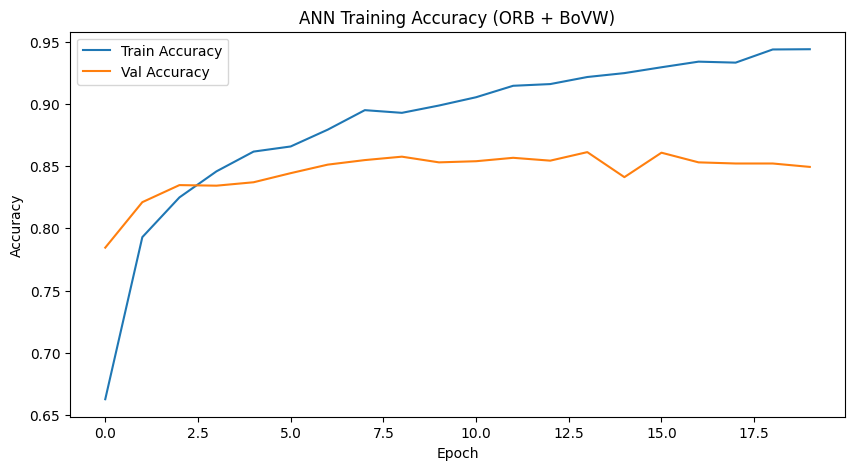

In [25]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('ANN Training Accuracy (ORB + BoVW)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [26]:
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Classification Report:
                 precision    recall  f1-score   support

Bacterialblight       0.97      0.99      0.98       481
      BrownSpot       0.89      0.86      0.87       615
        Healthy       0.72      0.77      0.75       441
      LeafBlast       0.82      0.79      0.80       653

       accuracy                           0.85      2190
      macro avg       0.85      0.85      0.85      2190
   weighted avg       0.85      0.85      0.85      2190



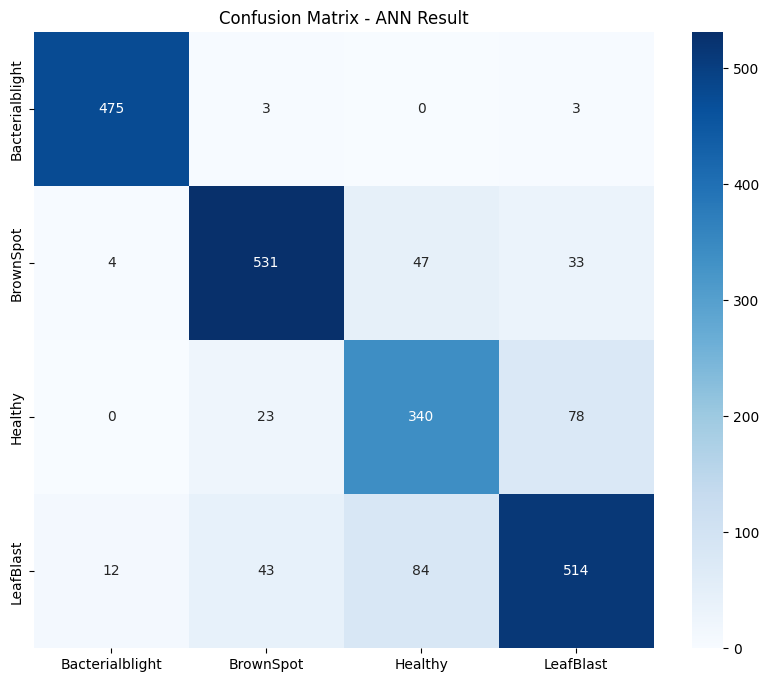

In [27]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - ANN Result')
plt.show()